In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')

### Data Loading

In [2]:
df1 = pd.read_csv('./Data/combined_data_1.txt', header = None, names = ['CustomerID', 'Rating', 'Date'])
df2 = pd.read_csv('./Data/combined_data_2.txt', header = None, names = ['CustomerID', 'Rating', 'Date'])
df3 = pd.read_csv('./Data/combined_data_3.txt', header = None, names = ['CustomerID', 'Rating', 'Date'])
df4 = pd.read_csv('./Data/combined_data_4.txt', header = None, names = ['CustomerID', 'Rating', 'Date'])

In [3]:
df = pd.concat([df1, df2, df3, df4], ignore_index=True)
df.head()

,CustomerID,Rating,Date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


In [4]:
print('sum of no. of rows in the 4 separate datasets:', df1.shape[0] + df2.shape[0] + df3.shape[0] + df4.shape[0])
print('shape of resulting dataset:', df.shape)

sum of no. of rows in the 4 separate datasets: 100498277
shape of resulting dataset: (100498277, 3)


### Data Analysis

In [5]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# number of movies
movie_count = np.sum(df['Rating'].isnull())

# number of customers
customer_count = df['CustomerID'].nunique() - movie_count

# number of ratings
rating_count = df.shape[0] - movie_count

In [6]:
p

,count
Rating,
1.0,4617990
2.0,10132080
3.0,28811247
4.0,33750958
5.0,23168232


Unhappy customers tend to just leave instead of making efforts to rate. Low rating movies mean they are generally really bad.

### Data Cleaning

In [7]:
from tqdm import tqdm

index_nan = list(df[df['Rating'].isnull() == True].index)
MovieID = []
movieID = 1
with tqdm(total=len(index_nan[1:])) as pbar:
    for i,j in zip(index_nan[1:], index_nan[:-1]):
        MovieID = np.append(MovieID, np.full((1, i-j-1),movieID))
        movieID = movieID + 1
        pbar.update(1)

100%|██████████| 17769/17769 [1:51:44<00:00,  2.65it/s]  


In [8]:
MovieID = np.append(MovieID, np.full((1,df.shape[0] - index_nan[-1] - 1),movieID))

In [9]:
df = df.dropna()
df['MovieID'] = MovieID

In [10]:
df.head()

,CustomerID,Rating,Date,MovieID
1,1488844,3.0,2005-09-06,1.0
2,822109,5.0,2005-05-13,1.0
3,885013,4.0,2005-10-19,1.0
4,30878,4.0,2005-12-26,1.0
5,823519,3.0,2004-05-03,1.0


In [11]:
df.to_csv('./Data/train.csv', index = False)

### Data Slicing

* Remove movie with too less reviews (they are relatively not popular)
* Remove customer who give too less reviews (they are relatively less active)

In [12]:
customer_insig = df.groupby('CustomerID')['Rating'].agg(['count','mean'])
movie_insig = df.groupby('MovieID')['Rating'].agg(['count','mean'])
customer_point = customer_insig['count'].quantile(0.7)
movie_point = movie_insig['count'].quantile(0.7)
customerID_remain = customer_insig[customer_insig['count'] > customer_point].index
movieID_remain = movie_insig[movie_insig['count'] > movie_point].index
df_cut = df[df['CustomerID'].isin(customerID_remain)]
df_cut = df_cut[df_cut['MovieID'].isin(movieID_remain)]

In [13]:
print('shape of original dataset:', df.shape)
print('shape of cut dataset:', df_cut.shape)
print('cutting point for Customer ID:', customer_point)
print('cutting point for Movie ID:', movie_point)

shape of original dataset: (100480507, 4)
shape of cut dataset: (71703703, 4)
cutting point for Customer ID: 211.0
cutting point for Movie ID: 1948.2999999999993


In [14]:
df_cut.head()

,CustomerID,Rating,Date,MovieID
696,712664,5.0,2004-02-01,3.0
697,1331154,4.0,2004-07-03,3.0
698,2632461,3.0,2005-07-22,3.0
699,44937,5.0,2004-06-22,3.0
700,656399,4.0,2003-09-20,3.0


In [15]:
df_cut.to_csv('./Data/train_cut.csv', index = False)

### Data Mapping

In [16]:
movie_title = pd.read_csv('./Data/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['MovieID', 'year', 'name'])
movie_title = movie_title.dropna()
movie_title['year'] = movie_title['year'].astype(int)
movies = pd.read_csv('./Data/movies.csv', encoding = "ISO-8859-1")

In [17]:
movie_title.head()

,MovieID,year,name
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW


In [18]:
movies.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


In [19]:
print('shape of Netflix movie dataset:', movie_title.shape)
print('shape of self-found movie dataset:', movies.shape)

shape of Netflix movie dataset: (17763, 3)
shape of self-found movie dataset: (6820, 15)


In [20]:
df_movie = pd.merge(movie_title, movies, on = ['name','year'])
df_movie.to_csv('./Data/df_movie.csv', index = False)
df_movie.head()

,MovieID,year,name,budget,company,country,director,genre,gross,rating,released,runtime,score,star,votes,writer
0,3,1997,Character,4500000.0,First Floor Features,Netherlands,Mike van Diem,Crime,713413.0,R,1998-03-27,122,7.8,Pavlik Jansen op de Haar,9512,Ferdinand Bordewijk
1,18,1994,Immortal Beloved,0.0,Icon Entertainment International,UK,Bernard Rose,Biography,9914409.0,R,1995-01-27,121,7.5,Gary Oldman,20038,Bernard Rose
2,30,2003,Something's Gotta Give,80000000.0,Columbia Pictures Corporation,USA,Nancy Meyers,Comedy,124728738.0,PG-13,2003-12-12,128,6.7,Jack Nicholson,96603,Nancy Meyers
3,45,1999,The Love Letter,20000000.0,DreamWorks,USA,Peter Ho-Sun Chan,Comedy,8276228.0,PG-13,1999-05-21,88,5.4,Kate Capshaw,3641,Cathleen Schine
4,55,1995,Jade,50000000.0,Paramount Pictures,USA,William Friedkin,Crime,9795017.0,R,1995-10-13,95,5.2,David Caruso,9815,Joe Eszterhas


In [21]:
print('shape of merged movie dataset:', df_movie.shape)
for i in ['company','country','director','genre','rating','star','writer']:
    print('No. of unique {}s in merged movie dataset:'.format(i), df_movie[i].nunique())

shape of merged movie dataset: (2805, 16)
No. of unique companys in merged movie dataset: 875
No. of unique countrys in merged movie dataset: 38
No. of unique directors in merged movie dataset: 1316
No. of unique genres in merged movie dataset: 16
No. of unique ratings in merged movie dataset: 8
No. of unique stars in merged movie dataset: 1121
No. of unique writers in merged movie dataset: 2022


In [22]:
df_movie.groupby('genre')['name'].agg(['count']).sort_values('count',ascending = False)

,count
genre,
Comedy,970
Drama,570
Action,565
Crime,225
Adventure,145
Biography,128
Animation,75
Horror,75
Fantasy,14


In [23]:
df_movie.groupby('country')['name'].agg(['count']).sort_values('count',ascending = False).head()

,count
country,
USA,2272
UK,233
France,80
Canada,39
Germany,34


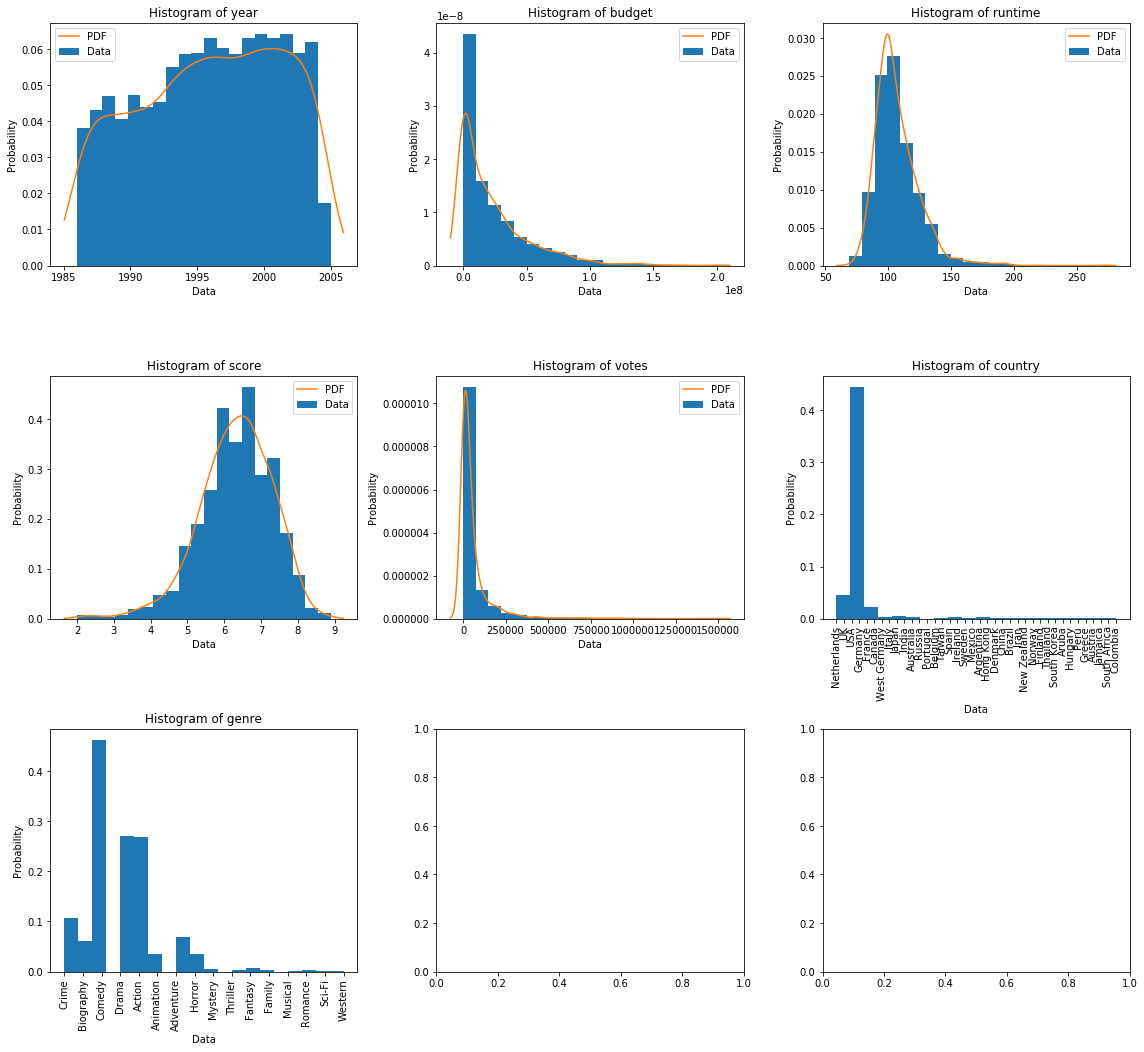

In [24]:
fig, axs = plt.subplots(3, 3, figsize=(16, 16))
axs = axs.ravel()
names = ['year', 'budget', 'runtime', 'score', 'votes', 'country', 'genre']
for i in range(len(names)):
    if i < 5:
        axs[i].hist(df_movie[names[i]], density = True, bins = 20, label = 'Data')
        mn, mx = axs[i].get_xlim()
        xs = np.linspace(mn, mx, 300)
        d = st.gaussian_kde(df_movie[names[i]])
        axs[i].plot(xs, d.pdf(xs), label = 'PDF')
        axs[i].legend()
        axs[i].set_ylabel('Probability')
        axs[i].set_xlabel('Data')
        axs[i].set_title('Histogram of {}'.format(names[i]))
    else:
        axs[i].hist(df_movie[names[i]].astype('category'), density = True, bins = 20)
        axs[i].set_ylabel('Probability')
        axs[i].set_xlabel('Data')
        axs[i].set_title('Histogram of {}'.format(names[i]))
        for t in axs[i].get_xticklabels():
            t.set_rotation(90)
        pass
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Data Combining

In [25]:
df_movie['MovieID'] = df_movie['MovieID'].astype(float)
df_merged = pd.merge(df, df_movie, on = ['MovieID'])
df_merged.to_csv('./Data/train_merged.csv', index = False)

### Target Dataset

In [26]:
df_partial = df.sample(n = 1000)
df_partial_target = df_partial.pivot_table(index = 'CustomerID', columns = 'MovieID', values = 'Rating')
df_partial_target.head()

MovieID,8.0,30.0,97.0,143.0,167.0,189.0,191.0,199.0,252.0,269.0,...,17540.0,17650.0,17654.0,17671.0,17681.0,17701.0,17709.0,17724.0,17762.0,17764.0
CustomerID,,,,,,,,,,,,,,,,,,,,,
1003859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1004219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1004390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1008039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1009477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
